In [1]:
import numpy as np
import pandas as pd 

In [2]:
from attention import AttentionLayer

In [3]:
articles = pd.read_csv("NYT_Dataset.csv")
articles = articles[['title','topic','abstract','keywords']]
# articles = articles.sample(n=500, random_state=26).reset_index()

In [4]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [5]:
display(articles)

,title,topic,abstract,keywords
0,"In Reversal, Pakistan Welcomes Outside Help With Inquiry on Bhutto",Foreign,Pakistan’s ambassador to the U.S. said his government would not endorse a separate inquiry modeled after one carried out by the U.N. after the assassination of Rafik Hariri of Lebanon in 2005.,"['Assassinations and Attempted Assassinations', 'Pakistan', 'Bhutto, Benazir', 'Federal Bureau of Investigation', 'United Nations']"
1,Fighting Intensifies After Election in Kenya,Foreign,"Kenya sank deeper into trouble, with a curfew imposed in Kisumu, the country’s third-largest city, ethnic fighting intensifying and more than 100 people killed in election-related violence.","['Kenya', 'Demonstrations and Riots', 'Odinga, Raila', 'Kibaki, Mwai', 'Elections']"
2,Israel: Olmert Curbs Settlements,Foreign,"Prime Minister Ehud Olmert has sent a letter to defense, housing and agriculture ministers, saying that his and the defense minister’s authorization would be required for any new building, plannin...",['West Bank']
3,Gay Muslims Pack a Dance Floor of Their Own,Foreign,The monthly club night known as Gayhane is an all-too-rare opportunity for gay Muslims to merge their immigrant cultures and their sexual identities.,"['Homosexuality', 'Islam', 'IMMIGRATION AND REFUGEES', 'Berlin (Germany)']"
4,Iraqi Revelers Embrace the New Year,Foreign,"But even as partygoers embraced the New Year, a surge of attacks on Monday served as a potent reminder that 2007 was the bloodiest on record.","['ARMAMENT, DEFENSE AND MILITARY FORCES', 'Iraq']"
...,...,...,...,...
106501,BAFTA Suspends Award for Actor Noel Clarke Amid Harassment Allegations,Foreign,"The British actor and director has been accused of sexual assault, harassment and bullying by 20 women in a published report.","['Sexual Harassment', 'Actors and Actresses', 'British Academy of Film and Television', 'Guardian (British Newspaper)', 'Great Britain']"
106502,The Bureaucrat From Buffalo Who Pushed Somalia to the Brink,Foreign,"His bid to stay in office an extra two years, without elections, has led to gunfights in the capital and fears that Somalia is backsliding into a disastrous conflict.","['Mohamed, Mohamed Abdullahi', 'Mogadishu (Somalia)', 'Somalia', 'Blinken, Antony J', 'Somali-Americans', 'Politics and Government', 'Buffalo (NY)']"
106503,What to Know About the Census Data,U.S.,The count reflects the slowest population growth since the 1930s. It also offers a glimpse of the shifting centers of population and power in the United States.,"['Census', 'Population', 'United States', 'Race and Ethnicity', 'Immigration and Emigration', 'North Dakota', 'Midwestern States (US)', 'Northeastern States (US)', 'Western States (US)', 'Southern..."
106504,"After 500 Years, an Ancient Bronze Hand Is Rejoined to a Finger",Foreign,"Researchers still don’t know how a finger belonging to a colossal statue of Emperor Constantine went missing, but this week, it was finally reattached in Rome.","['Art', 'Roman Civilization', 'Capitoline Museums', 'Louvre Museum', 'Rome (Italy)']"


In [6]:
import re
# get NLTK libraries
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))

def clean_text(text, remove_stopwords = True):
    # Simple text break
    # data cleaning
    
    text = re.sub("(\\t)", ' ', str(text)).lower() #remove escape charecters
    text = re.sub("(\\r)", ' ', str(text)).lower() 
    text = re.sub("(\\n)", ' ', str(text)).lower()

    text = re.sub("(__+)", ' ', str(text)).lower()   #remove _ if it occors more than one time consecutively
    text = re.sub("(--+)", ' ', str(text)).lower()   #remove - if it occors more than one time consecutively
    text = re.sub("(~~+)", ' ', str(text)).lower()   #remove ~ if it occors more than one time consecutively
    text = re.sub("(\+\++)", ' ', str(text)).lower()   #remove + if it occors more than one time consecutively
    text = re.sub("(\.\.+)", ' ', str(text)).lower()   #remove . if it occors more than one time consecutively

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower() #remove <>()|&©ø"',;?~*!

    text = re.sub("(mailto:)", ' ', str(text)).lower() #remove mailto:
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower() #remove \x9* in text
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower() #replace INC nums to INC_NUM
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(text)).lower() #replace CM# and CHG# to CM_NUM


    text = re.sub("(\.\s+)", ' ', str(text)).lower() #remove full stop at end of words(not between)
    text = re.sub("(\-\s+)", ' ', str(text)).lower() #remove - at end of words(not between)
    text = re.sub("(\:\s+)", ' ', str(text)).lower() #remove : at end of words(not between)

    text = re.sub("(\s+.\s+)", ' ', str(text)).lower() #remove any single charecters hanging between 2 spaces
    text = re.sub("(\s+)",' ',str(text)).lower() #remove multiple spaces
        
    #Sho uld always be last
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower() #remove any single charecters hanging between 2 spaces

    if remove_stopwords:
        tokens = [w for w in text.split() if not w in stop_words]
    else:
        tokens=text.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()
    return text

In [7]:
from tqdm.notebook import tqdm
tqdm.pandas()
articles['Cleaned_abstract'] = articles['abstract'].progress_apply(clean_text)
articles['Cleaned_title'] = articles['title'].progress_apply(clean_text)

  0%|          | 0/106506 [00:00<?, ?it/s]

  0%|          | 0/106506 [00:00<?, ?it/s]

In [8]:
display(articles['Cleaned_abstract'])

0                                                                       pakistan’s ambassador u.s said government would endorse separate inquiry modeled one carried u.n assassination rafik hariri lebanon 2005.
1                                                          kenya sank deeper trouble curfew imposed kisumu country’s third-largest city ethnic fighting intensifying 100 people killed election-related violence.
2         prime minister ehud olmert sent letter defense housing agriculture ministers saying defense minister’s authorization would required new building planning land expropriation jewish settlements west...
3                                                                                               monthly club night known gayhane all-too-rare opportunity gay muslims merge immigrant cultures sexual identities.
4                                                                                                            even partygoers embraced new year surge attacks mon

In [9]:
display(articles['Cleaned_title'])

0                                  reversal pakistan welcomes outside help inquiry bhutto
1                                                     fighting intensifies election kenya
2                                                         israel olmert curbs settlements
3                                                            gay muslims pack dance floor
4                                                         iraqi revelers embrace new year
                                               ...                                       
106501                 bafta suspends award actor noel clarke amid harassment allegations
106502                                            bureaucrat buffalo pushed somalia brink
106503                                                                   know census data
106504                                      500 years ancient bronze hand rejoined finger
106505    indoor dining new york city expand 75 percent capacity next week governor says.
Name: Clea

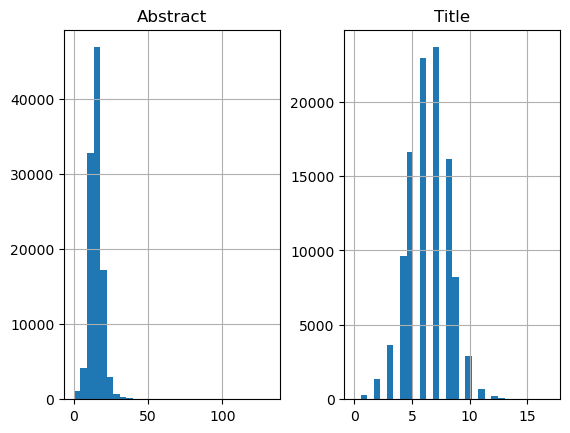

In [10]:
import matplotlib.pyplot as plt

abstract_word_count = []
title_word_count = []

# populate the lists with sentence lengths
for i in articles['Cleaned_abstract']:
      abstract_word_count.append(len(i.split()))

for i in articles['Cleaned_title']:
      title_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Abstract':abstract_word_count, 'Title':title_word_count})

length_df.hist(bins = 30)
plt.show()

In [11]:
cnt=0
for i in articles['Cleaned_title']:
    if(len(i.split())<=9):
        cnt=cnt+1
print(cnt/len(articles['Cleaned_title']))

0.9627063264041462


In [12]:
max_abstract_len=30
max_title_len=9

In [13]:
cleaned_abstract = np.array(articles['Cleaned_abstract'])
cleaned_title = np.array(articles['Cleaned_title'])

short_abstract=[]
short_title=[]

for i in range(len(cleaned_abstract)):
    if(len(cleaned_title[i].split())<=max_title_len and len(cleaned_abstract[i].split())<=max_abstract_len):
        short_abstract.append(cleaned_abstract[i])
        short_title.append(cleaned_title[i])
        
df=pd.DataFrame({'abstract':short_abstract,'title':short_title})

In [14]:
df['title'] = df['title'].progress_apply(lambda x : 'sostok '+ x + ' eostok')

  0%|          | 0/101936 [00:00<?, ?it/s]

In [15]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['abstract']),np.array(df['title']),test_size=0.1,random_state=26,shuffle=True)

In [16]:
import tensorflow as tf

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [18]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 42.57675073140022
Total Coverage of rare words: 1.6842879389630576


In [19]:
#prepare a tokenizer for reviews on training data
# x_tokenizer = Tokenizer(num_words=tot_cnt-cnt, oov_token='<unk>') 
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_abstract_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_abstract_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [20]:
x_voc

31013

In [21]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [22]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 42.747579610404756
Total Coverage of rare words: 1.8867098863392113


In [23]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_title_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_title_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 19634


In [24]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(91742, 91742)

In [25]:
# deleting the rows that contain only START and END tokens
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [26]:
# deleting the rows that contain only START and END tokens
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [27]:
from attention import AttentionLayer
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(max_abstract_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

print(type(decoder_outputs))
print(isinstance(decoder_outputs, type(encoder_outputs)))
print(decoder_outputs.shape)
print(type(decoder_outputs.shape))

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 


<class 'keras.src.backend.common.keras_tensor.KerasTensor'>
True
(None, None, 300)
<class 'tuple'>


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 30)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 30, 100)           │       3,101,300 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 30, 300), (None,  │         481,200 │ embedding[0][0]            │
│                               │ 300), (None, 300)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ [(None, 30, 300), (None,  │         721,200 │ lstm[0][0]                 │
│                               │ 300), (None, 300)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, None, 100)         │       1,963,400 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ [(None, 30, 300), (None,  │         721,200 │ lstm_1[0][0]               │
│                               │ 300), (None, 300)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_3 (LSTM)                 │ [(None, None, 300),       │         481,200 │ embedding_1[0][0],         │
│                               │ (None, 300), (None, 300)] │                 │ lstm_2[0][1], lstm_2[0][2] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_layer               │ [(None, None, 300),       │         180,300 │ lstm_2[0][0], lstm_3[0][0] │
│ (AttentionLayer)              │ (None, None, 30)]         │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concat_layer (Concatenate)    │ (None, None, 600)         │               0 │ lstm_3[0][0],              │
│                               │                           │                 │ attention_layer[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed              │ (None, None, 19634)       │      11,800,034 │ concat_layer[0][0]         │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 19,449,834 (74.20 MB)

 Trainable params: 19,449,834 (74.20 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [29]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [30]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 463s 637ms/step - loss: 6.8343 - val_loss: 6.0399
Epoch 2/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 433s 603ms/step - loss: 6.1231 - val_loss: 5.9438
Epoch 3/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 434s 606ms/step - loss: 6.0156 - val_loss: 5.7968
Epoch 4/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 460s 641ms/step - loss: 5.8468 - val_loss: 5.6682
Epoch 5/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 486s 677ms/step - loss: 5.7088 - val_loss: 5.6232
Epoch 6/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 430s 599ms/step - loss: 5.6000 - val_loss: 5.5365
Epoch 7/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 433s 604ms/step - loss: 5.5496 - val_loss: 5.4964
Epoch 8/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 454s 633ms/step - loss: 5.4771 - val_loss: 5.4393
Epoch 9/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 454s 634ms/step - loss: 5.3814 - val_loss: 5.3890
Epoch 10/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 457s 638ms/step - loss: 5.3300 - val_loss: 5.3455
Epoch 11/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 457s 638ms/step - loss: 5.2426 - val_loss: 5.3113
Epoch 12

In [38]:
model.save_weights("LSTM_100k_attention.weights.h5")

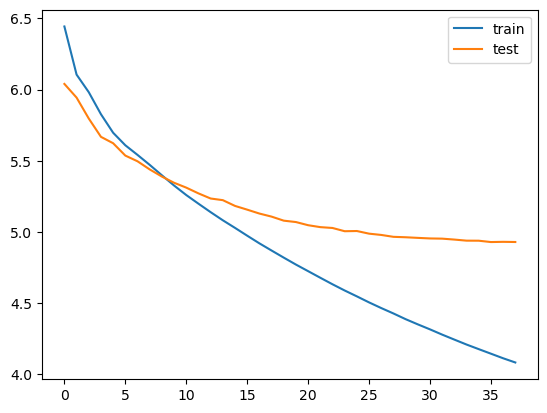

In [32]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [33]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [34]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_abstract_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [35]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_abstract_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [36]:
def seq2title(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2abstract(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [37]:
for i in range(0,100):
    print("Abstract:",seq2abstract(x_tr[i]))
    print("Original Title:",seq2title(y_tr[i]))
    print("Predicted Title:",decode_sequence(x_tr[i].reshape(1,max_abstract_len)))
    print("\n")

Abstract: mohammad 27 wounded 15 people last month three years entering europe illegally bulgaria received mental health therapy full identity motives remain unclear 
Original Title: suicide bomber made way syria strike ansbach germany 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Title:  greece raises death toll


Abstract: one small circle al qaeda operatives explored ways follow new terror attacks according classified files 
Original Title: dossier shows push attacks 9 11 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Title:  american group finds drone strikes


Abs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Title:  china investigates trial


Abstract: see latest charts maps coronavirus cases deaths hospitalizations marion county mississippi 
Original Title: marion county mississippi covid case risk tracker 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Title:  county mississippi covid case risk tracker


Abstract: daughters woman held one ireland’s notorious magdalene laundries campaigning apology state 10 years 
Original Title: seeking redress mother’s life workhouse 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Title:  coronavirus lockdown


Abstract: 18 months solitary confinement turkish employee united states consulate denied release despite american protests charges baseless 
Original Title: trial u s consular employee highlights rift relations 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Title:  turkey frees journalists held journalists


Abstract: pride celebrated country first black superstar known hits angel good “is anybody san died saturday age 86 care dallas 
Original Title: pride country music star dies complications covid 19 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Title:  south korean president apologizes


Abstract: brazil’s leader coronavirus skeptic mocked public health measures deaths skyrocketing ally president trump closed door 
Original Title: u s bans flights brazil pandemic raging 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Title:  trump’s coronavirus vaccine


Abstract: american drone fired missiles compound orakzai tribal region thursday killing 18 afghans wounding 4 
Original Title: pakistan drone strike kills 18 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Title:  pa

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Title:  protesters protest protesters rally


Abstract: three men say sexually abused teenagers prominent catholic priest filed lawsuit roman catholic archdiocese santiago 
Original Title: chile sue sexual abuse cases 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Title:  abuse case pope


